# PINNs-NN-函数拟合  
为了说明物理信息神经网络和神经网络在进行函数拟合方面的区别，进行如下仿真。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sciann as sn
import tensorflow as tf

---------------------- SCIANN 0.6.3.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 


# 算例介绍  
## 采用神经网络训练
仿真的目标是使用sciann进行函数拟合，首先假设我们有根据公式得到的“仿真”数据集：
$$f(x)=sin(x)sin(y)$$

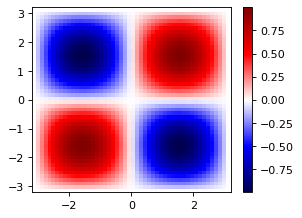

In [2]:
x_data, y_data = np.meshgrid(
    np.linspace(-np.pi, np.pi, 50),
    np.linspace(-np.pi, np.pi, 50),
    )
f_data = np.sin(x_data) * np.sin(y_data)
plt.figure(figsize=(4,3), dpi=80)
plt.pcolor(x_data, y_data, f_data, cmap='seismic', shading='nearest')
plt.colorbar()
plt.show()

# Step 1   
第一步还是设定仿真函数和变量，在sciann中采用如下形式：

In [3]:
x = sn.Variable('x')
y = sn.Variable('y')
f = sn.Functional('f', [x, y], [10, 10, 10, 10], 'l-tanh', res_net=True)

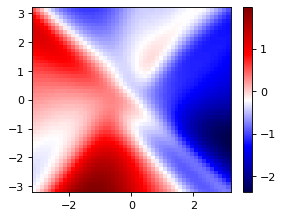

In [4]:
# 网络确定后，可以对初值进行提取和评价
f_pred = f.eval([x_data, y_data])
plt.figure(figsize=(4,3), dpi=80)
im = plt.pcolor(x_data, y_data, f_pred, cmap='seismic', shading='nearest')
plt.colorbar(im)
plt.show()

从这个图可以看到初始值和真值相差是很大的

# Step 2
第二步是设定寻优模型，需要设定输入和目标，调用SciModel接口设定比较方便：

In [5]:
d1 = sn.Data(f)
m = sn.SciModel([x, y], d1)

In [ ]:
# 然后可以用.train执行训练
h = m.train([x_data, y_data], 
            f_data, 
            learning_rate=0.002, 
            epochs=1500)


Total samples: 2500 
Batch size: 64 
Total batches: 40 

Epoch 1/1500
40/40 [==============================] - 1s 18ms/step - loss: 0.2441
Epoch 2/1500
40/40 [==============================] - 0s 5ms/step - loss: 0.0876
Epoch 3/1500
40/40 [==============================] - 0s 6ms/step - loss: 0.0636
Epoch 4/1500
40/40 [==============================] - 0s 6ms/step - loss: 0.0512
Epoch 5/1500
40/40 [==============================] - 0s 6ms/step - loss: 0.0428
Epoch 6/1500
40/40 [==============================] - 0s 6ms/step - loss: 0.0364
Epoch 7/1500
40/40 [==============================] - 0s 6ms/step - loss: 0.0288
Epoch 8/1500
40/40 [==============================] - 0s 6ms/step - loss: 0.0233
Epoch 9/1500
40/40 [==============================] - 0s 6ms/step - loss: 0.0196
Epoch 10/1500
40/40 [==============================] - 0s 6ms/step - loss: 0.0186
Epoch 11/1500
40/40 [==============================] - 0s 5ms/step - loss: 0.0141
Epoch 12/1500
40/40 [===========================

In [ ]:
# 训练历史可以通过函数调用
plt.semilogy(h.history['loss'])
plt.show()

我们现在采用更大的变量范围测试拟合结果，$x,y\in [-2\pi , 2 \pi]$

In [ ]:
x_test, y_test = np.meshgrid(np.linspace(-2*np.pi, 2*np.pi, 100), np.linspace(-2*np.pi, 2*np.pi, 100))
f_test = np.sin(x_test) * np.sin(y_test)

f_pred = f.eval([x_test, y_test])

fig = plt.figure(3, figsize=(8, 3), dpi=80)
ax = plt.subplot(1, 2, 1)
h1 = ax.pcolormesh(x_test, y_test, f_test, 
                   cmap='seismic', shading='nearest',
                   vmin=-1, vmax=1)
fig.colorbar(h1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('exact')
ax = plt.subplot(1, 2, 2)
h2 = ax.pcolormesh(x_test, y_test, f_pred, cmap='seismic', 
                   shading='nearest',
                   vmin=-1, vmax=1
                  )
plt.colorbar(h2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('NN-Pred')
plt.show()

## 采用物理信息神经网络  
这里函数：$f(x)=sin(x)sin(y)$满足以下齐次偏微分方程（PDE）：
$$f_{xx}+f_{yy}+2f=0$$  
我们把这个PDE作为损失函数的一部分

## Step 1  
定义网络

In [ ]:
x = sn.Variable('x')
y = sn.Variable('y')
f = sn.Functional('f', [x, y], [10, 10, 10, 10], 'l-tanh', res_net=True)

## Step 2  
定义目标函数和优化模型

In [ ]:
f_xx = sn.math.diff(f, x, order=2)
f_yy = sn.math.diff(f, y, order=2)
L = f_xx + f_yy + 2*f

d1 = sn.Data(f)
d2 = sn.Data(L)
m = sn.SciModel([x, y], [d1, d2])

h = m.train([x_data, y_data], [f_data, 'zero'], learning_rate=0.002, epochs=1500)

In [ ]:
plt.semilogy(h.history['loss'])
plt.show()

In [ ]:
x_test, y_test = np.meshgrid(np.linspace(-2*np.pi, 2*np.pi, 100), np.linspace(-2*np.pi, 2*np.pi, 100))
f_test = np.sin(x_test) * np.sin(y_test)

f_pred = f.eval([x_test, y_test])

fig = plt.figure(3, figsize=(8, 3), dpi=80)
ax = plt.subplot(1, 2, 1)
h1 = ax.pcolormesh(x_test, y_test, f_test, cmap='seismic',
                  shading='nearest',
                   vmin=-1, vmax=1)
fig.colorbar(h1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('exact')

ax = plt.subplot(1, 2, 2)
h2 = ax.pcolormesh(x_test, y_test, f_pred, cmap='seismic',
                 shading='nearest',
                   vmin=-1, vmax=1)
plt.colorbar(h2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('PINNs-Pred')

plt.show()

对于同样多数据驱动的模型，PINNs具有更高的精度和预测性。